<a href="https://colab.research.google.com/github/Chandankumark28/FINGER-VEIN-AUTHENTICATION-/blob/main/capstoneproject_fva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving 1copy.jpg to 1copy.jpg
Saving 2.jpg to 2.jpg
Images uploaded: ['1copy.jpg', '2.jpg']
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


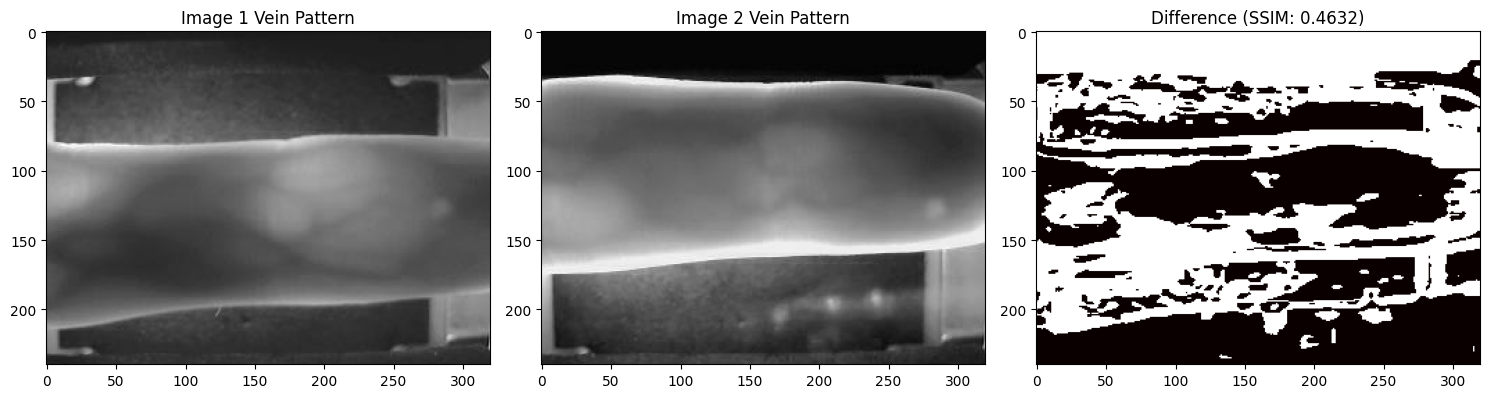

SSIM Score (Similarity): 0.4632
The images belong to different person.


In [ ]:
# Install necessary packages
!pip install tensorflow opencv-python

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Reshape, UpSampling2D, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# --- Step 1: Image Acquisition (Upload two images for authentication) ---
uploaded = files.upload()  # Upload two images for authentication
authentication_images = list(uploaded.keys())  # Get the file names

if len(authentication_images) != 2:
    print("Please upload exactly two images.")
else:
    print(f"Images uploaded: {authentication_images}")

# --- Step 2: Image Preprocessing ---
# Function to preprocess images (convert to grayscale, normalize, and resize)
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read image as grayscale
    img = img / 255.0  # Normalize pixel values to [0, 1]
    img = cv2.resize(img, (128, 128))  # Resize image to 128x128
    return img.reshape(128, 128, 1)  # Reshape for the input shape of the model

preprocessed_image1 = preprocess_image(authentication_images[0])
preprocessed_image2 = preprocess_image(authentication_images[1])

# --- Step 3: Feature Extraction (Siamese Network) ---
input_shape = (128, 128, 1)

# Encoder Model
input_img = Input(shape=input_shape)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
encoded = Dense(128, activation='relu')(x)  # Adaptive encoding

# Build the Encoder model
encoder_model = Model(input_img, encoded)

# Inputs for the Siamese Network
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# Use the encoder model for both inputs (image1 and image2)
encoded_a = encoder_model(input_a)
encoded_b = encoder_model(input_b)

# Calculate distance between the two encoded images
distance = Lambda(lambda x: tf.sqrt(tf.reduce_sum(tf.square(x[0] - x[1]), axis=-1)))([encoded_a, encoded_b])

# Build Siamese Network model
siamese_net = Model(inputs=[input_a, input_b], outputs=distance)

# --- Step 4: Decision Making (Compare the images and classify) ---
# Expand dimensions for prediction (Siamese model expects batch of images)
preprocessed_image1 = np.expand_dims(preprocessed_image1, axis=0)
preprocessed_image2 = np.expand_dims(preprocessed_image2, axis=0)

# Predict the distance between the two images
distance_value = siamese_net.predict([preprocessed_image1, preprocessed_image2])

# Calculate mean distance
mean_distance = np.mean(distance_value)

# Set a threshold for classification (adjust based on experimentation)
threshold = 0.5  # You may adjust this threshold based on the model performance



# --- Optional: Display the Images and Compare (using SSIM to show similarities) ---
from skimage.metrics import structural_similarity as compare_ssim

def display_images(image1_path, image2_path):
    img1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)

    # Compute SSIM (Structural Similarity Index) between the images
    ssim_score, diff = compare_ssim(img1, img2, full=True)
    diff = (diff * 255).astype("uint8")  # Convert difference to uint8 format

    # Threshold to highlight differences
    thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    # Display the images and difference
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Image 1 Vein Pattern")
    plt.imshow(img1, cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title("Image 2 Vein Pattern")
    plt.imshow(img2, cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title(f"Difference (SSIM: {ssim_score:.4f})")
    plt.imshow(thresh, cmap='hot')

    plt.tight_layout()
    plt.show()

    # Print SSIM score
    print(f"SSIM Score (Similarity): {ssim_score:.4f}")
    if ssim_score < 1.0:
        print("The images belong to different person.")
    else:
        print("The images belong to same person.")

# Visualize the images and differences
display_images(authentication_images[0], authentication_images[1])